In [125]:
import os
import json
import math
import pandas as pd
import configparser
from snowflake.snowpark import Session
from copy import copy
from snowflake.snowpark import Row
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col, lit, sql_expr, get, get_path, udf, udtf, table_function, sproc, seq8, uniform, when_matched, when_not_matched, cast, try_cast, asc, asc_nulls_first, asc_nulls_last, collate, startswith, endswith, equal_nan, is_null, in_, when
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, DecimalType, LongType
from snowflake.snowpark.exceptions import SnowparkJoinException, SnowparkSQLException
from snowflake.snowpark.files import SnowflakeFile
from snowflake.snowpark.column import METADATA_FILENAME, METADATA_FILE_ROW_NUMBER

# Read snowflake credentials securely
config = configparser.ConfigParser()
config.read('assets/credentials.cfg')

connection_parameters = dict(
   account   =  config['SNOWPARKAWS']['SNOWFLAKE_ACCOUNT'],
   user      =  config['SNOWPARKAWS']['SNOWFLAKE_USER'],
   password  =  config['SNOWPARKAWS']['SNOWFLAKE_PASSWORD'],
   role      =  config['SNOWPARKAWS']['SNOWFLAKE_ROLE'],  # optional
   warehouse =  config['SNOWPARKAWS']['SNOWFLAKE_WAREHOUSE'],  # optional
   database  =  config['SNOWPARKAWS']['SNOWFLAKE_DATABASE'],  # optional
   schema    =  config['SNOWPARKAWS']['SNOWFLAKE_SCHEMA'],  # optional
)

# Pass this dictionary to the Session.builder.configs method to return a builder object that has these connection parameters.
# Call the create method of the builder to establish the session.
session = Session.builder.configs(connection_parameters).create()

#### `Understanding snowflake.snowpark.Column`

snowflake.snowpark.Column represents a column or an expression in a DataFrame.

To access a Column object that refers a column in a DataFrame, you can:

- Use the column name.
- Use the functions.col() function.
- Use the DataFrame.col() method.
- Use the index operator [] on a dataframe object with a column name.
- Use the dot operator . on a dataframe object with a column name.

To create a Column object that represents a constant value, use [snowflake.snowpark.functions.lit()](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.lit):

In [4]:
from snowflake.snowpark.functions import col
# READING TABLE DATA
q_history = session.table('SNOWFLAKE.ACCOUNT_USAGE.QUERY_HISTORY').limit(10)

# SELECTING QUERY_ID COLUMN USING COLUMN NAME
print("SELECTING QUERY_ID COLUMN USING COLUMN NAME")
q_history.select('query_id').limit(2).show()

# SELECTING QUERY_ID USING DataFrame.col() METHOD
print("SELECTING QUERY_ID USING DataFrame.col() METHOD")
q_history.select(q_history.col('query_id')).limit(2).show()

# SELECTING QUERY_ID USING col() function
print("SELECTING QUERY_ID USING col() function")
q_history.select(col('query_id')).limit(2).show()

# SELECTING QUERY_ID USING INDEX OPERATOR [] ON DataFrame
print("SELECTING QUERY_ID USING INDEX OPERATOR [] ON DataFrame")
q_history.select(q_history['query_id']).limit(2).show()

# SELECTING QUERY_ID USING DOT OPERATOR . ON DataFrame
print("SELECTING QUERY_ID USING DOT OPERATOR . ON DataFrame")
q_history.select(q_history.query_id).limit(2).show()

SELECTING QUERY_ID COLUMN USING COLUMN NAME
----------------------------------------
|"QUERY_ID"                            |
----------------------------------------
|01b037e0-0404-d217-0000-000202db7009  |
|01b037e0-0404-d17f-0000-000202db2005  |
----------------------------------------

SELECTING QUERY_ID USING DataFrame.col() METHOD
----------------------------------------
|"QUERY_ID"                            |
----------------------------------------
|01b037e0-0404-d217-0000-000202db7009  |
|01b037e0-0404-d17f-0000-000202db2005  |
----------------------------------------

SELECTING QUERY_ID USING col() function
----------------------------------------
|"QUERY_ID"                            |
----------------------------------------
|01b037e0-0404-d217-0000-000202db7009  |
|01b037e0-0404-d17f-0000-000202db2005  |
----------------------------------------

SELECTING QUERY_ID USING INDEX OPERATOR [] ON DataFrame
----------------------------------------
|"QUERY_ID"                   

 - [functions](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/functions)

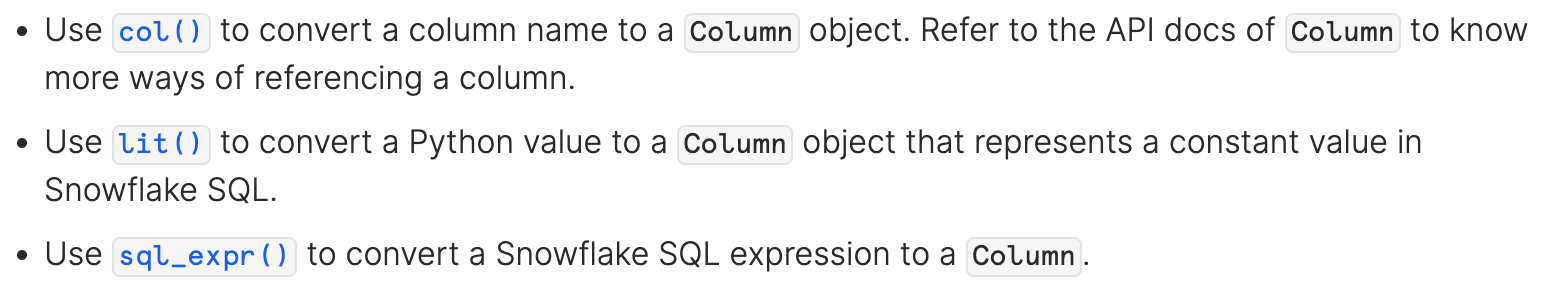

In [11]:
from snowflake.snowpark.functions import col, lit, sql_expr
df = session.create_dataframe([[1,'a',True,'2023-12-15'], [3,'b',False,'2023-12-16']], schema=["a", "b", "c", "d"])
df.show()

----------------------------------
|"A"  |"B"  |"C"    |"D"         |
----------------------------------
|1    |a    |True   |2023-12-15  |
|3    |b    |False  |2023-12-16  |
----------------------------------



In [6]:
df.filter(col("a") == 1).show()

---------------------------------
|"A"  |"B"  |"C"   |"D"         |
---------------------------------
|1    |a    |True  |2023-12-15  |
---------------------------------



In [7]:
df.filter(col("a") == lit(1)).show()

---------------------------------
|"A"  |"B"  |"C"   |"D"         |
---------------------------------
|1    |a    |True  |2023-12-15  |
---------------------------------



In [10]:
df.filter(sql_expr("a = 3")).show()

----------------------------------
|"A"  |"B"  |"C"    |"D"         |
----------------------------------
|3    |b    |False  |2023-12-16  |
----------------------------------



#### `Understanding utility functions for constructing expressions with Columns`

- Column objects can be built with the operators, summarized by operator precedence, in the following table:

| Operator | Description |
| -- | -- |
| x[index] | Index operator to get an item out of a Snowflake ARRAY or OBJECT |
| ** | Power |
| -x, ~x | Unary minus, unary not |
| *, /, % | Multiply, divide, remainder | 
| +, - | Plus, minus | 
| & | And |
| &#124; | Or |
| ==, !=, <, <=, >, >= | Equal to, not equal to, less than, less than or equal to, greater than, greater than or equal to | 

In [19]:
from snowflake.snowpark.types import StructField, StructType, IntegerType,StringType

schema = StructType([StructField('num1',IntegerType()) ,StructField('num2',IntegerType())])
df = session.create_dataframe([[20,34],[10,2],[10,10],[11,53]],schema=schema)
df.show()

-------------------
|"NUM1"  |"NUM2"  |
-------------------
|20      |34      |
|10      |2       |
|10      |10      |
|11      |53      |
-------------------



In [17]:
df.select((col("NUM1")**2).as_("res")).show()

---------
|"RES"  |
---------
|400.0  |
|100.0  |
|100.0  |
|121.0  |
---------



In [20]:
# PEMDAS - Order of operation
df.select(col('num1') + col('num2') * col('num1') -2 / col('num1')%3).show()

------------------------------------------------------
|"((""NUM1"" + (""NUM2"" * ""NUM1"")) - ((2 :: I...  |
------------------------------------------------------
|699.900000                                          |
|29.800000                                           |
|109.800000                                          |
|593.818182                                          |
------------------------------------------------------



In [22]:
df.filter((col("num1") > 10) & (col("num1") < 20)).show()

-------------------
|"NUM1"  |"NUM2"  |
-------------------
|11      |53      |
-------------------



In [24]:
df.filter((col("num1") == 11) | (col("num1") == 20)).show()

-------------------
|"NUM1"  |"NUM2"  |
-------------------
|20      |34      |
|11      |53      |
-------------------



#### `Hands-on of methods for the most frequently used column transformations and operators`


| Methods | Description |
| -- | -- |
| Column.astype(to) / Column.cast(to) / Column.try_cast(to) | Casts the value of the Column to the specified data type. |
| Column.as_(alias) / Column.alias(alias) | Returns a new renamed Column. |
| DataFrame.sort | Sorts a DataFrame by the specified expressions (similar to ORDER BY in SQL).|
| Column.asc() / Column.asc_nulls_first() / Column.asc_nulls_last() |  Returns a Column expression with values sorted in ascending order | 
| Column.desc() / Column.desc_nulls_first() / Column.desc_nulls_last() | Returns a Column expression with values sorted in descending order. |
| Column.between(lower_bound, upper_bound) | Between lower bound and upper bound. |
| Column.collate(collation_spec) | Returns a copy of the original Column with the specified collation_spec property, rather than the original collation specification property. |
| Column.startswith(other) | Returns true if this Column starts with another string. |
| Column.endswith(other) | Returns true if this Column ends with another string. |
| Column.eqNullSafe(other) / Column.equal_null(other) | Equal to. |
| Column.isNotNull() / Column.equal_nan() | Is NaN or Not Null. |
| Column.in_(*vals) / Column.isin(vals)  | Returns a conditional expression that you can pass to the DataFrame.filter() or where DataFrame.where() to perform the equivalent of a WHERE . |
| Column.like(pattern) | Allows case-sensitive matching of strings based on comparison with a pattern. |
| Column.substring(start_pos, length) / Column.substr(start_pos, length) | Returns a substring of this string column. |
| CaseExpr.when(condition, value) | Appends one more WHEN condition to the CASE expression.|
| CaseExpr.otherwise(value) | Sets the default result for this CASE expression. |

- [functions.cast]('https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.cast)
- [functions.try_cast](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.try_cast)

In [27]:
from snowflake.snowpark.functions import col, lit, cast
from snowflake.snowpark.types import IntegerType, DecimalType

df = session.create_dataframe([[1.5432]], schema=["d"])
# cast function
df.select(col("d")
         ,cast(col("d"), DecimalType(15,2)).alias("decimal")
         ,cast(col("d"), IntegerType()).alias("Integer")).show()

----------------------------------
|"D"     |"DECIMAL"  |"INTEGER"  |
----------------------------------
|1.5432  |1.54       |2          |
----------------------------------



In [31]:
# cast method
df = session.create_dataframe([[1.5432]], schema=["d"])
df.select(col("d").cast(IntegerType()).as_("res")).show()

---------
|"RES"  |
---------
|2      |
---------



In [40]:
df = session.create_dataframe(['0','-12','22','1001','Hello'], schema=["a"])
df.show()

---------
|"A"    |
---------
|0      |
|-12    |
|22     |
|1001   |
|Hello  |
---------



In [41]:
# try_cast()
df.select(try_cast(col("a"), IntegerType()).alias("ans")).show()

---------
|"ANS"  |
---------
|0      |
|-12    |
|22     |
|1001   |
|NULL   |
---------



- [DataFrame.sort](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrame.sort)

In [50]:
from snowflake.snowpark.functions import col

df = session.create_dataframe([[1,2],[3,4],[1,4]], schema=["col1","col2"])
df.show()

-------------------
|"COL1"  |"COL2"  |
-------------------
|1       |2       |
|3       |4       |
|1       |4       |
-------------------



In [54]:
# sort method
df.sort(col("col1").asc(), col("col2").asc()).show()

df.sort(col("col1").desc(), col("col2").desc()).show()

df.sort(col("col1"), ascending=False).show()

-------------------
|"COL1"  |"COL2"  |
-------------------
|1       |2       |
|1       |4       |
|3       |4       |
-------------------

-------------------
|"COL1"  |"COL2"  |
-------------------
|3       |4       |
|1       |4       |
|1       |2       |
-------------------

-------------------
|"COL1"  |"COL2"  |
-------------------
|3       |4       |
|1       |2       |
|1       |4       |
-------------------



- [functions.asc](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.asc)
- [functions.asc_nulls_first](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.asc_nulls_first)
- [functions.asc_nulls_last](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.asc_nulls_last)

In [34]:
from snowflake.snowpark.functions import asc, asc_nulls_first, asc_nulls_last
df = session.create_dataframe([None,3,2,1,None], schema=["col1"])
df.show()

df.sort(asc(df["col1"])).show()

df.sort(asc_nulls_first(df["col1"])).show()

df.sort(asc_nulls_last(df["col1"])).show()

----------
|"COL1"  |
----------
|NULL    |
|3       |
|2       |
|1       |
|NULL    |
----------

----------
|"COL1"  |
----------
|NULL    |
|NULL    |
|1       |
|2       |
|3       |
----------

----------
|"COL1"  |
----------
|NULL    |
|NULL    |
|1       |
|2       |
|3       |
----------

----------
|"COL1"  |
----------
|1       |
|2       |
|3       |
|NULL    |
|NULL    |
----------



- [functions.desc](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.desc)
- [functions.desc_nulls_first](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.desc_nulls_first)
- [functions.desc_nulls_last](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.desc_nulls_last)

In [43]:
from snowflake.snowpark.functions import asc, asc_nulls_first, asc_nulls_last, desc, desc_nulls_first, desc_nulls_last
df = session.create_dataframe([None,3,2,1,None], schema=["col1"])
df.show()

df.sort(desc(df["col1"])).show()
df.sort(desc_nulls_first(df["col1"])).show()
df.sort(desc_nulls_last(df["col1"])).show()

----------
|"COL1"  |
----------
|NULL    |
|3       |
|2       |
|1       |
|NULL    |
----------

----------
|"COL1"  |
----------
|3       |
|2       |
|1       |
|NULL    |
|NULL    |
----------

----------
|"COL1"  |
----------
|NULL    |
|NULL    |
|3       |
|2       |
|1       |
----------

----------
|"COL1"  |
----------
|3       |
|2       |
|1       |
|NULL    |
|NULL    |
----------



- [Column.between](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Column.between)

In [56]:
df = session.create_dataframe([10,20,30,40,50,60,70,80], schema=["col1"])
df.show()

----------
|"COL1"  |
----------
|10      |
|20      |
|30      |
|40      |
|50      |
|60      |
|70      |
|80      |
----------



In [57]:
# between 
df.filter(col("col1").between(40,60)).show()

----------
|"COL1"  |
----------
|40      |
|50      |
|60      |
----------



- [functions.collate](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.collate)
- [Collation Support](https://docs.snowflake.com/en/sql-reference/collation#label-collation-specification)

In [60]:
df = session.create_dataframe(['ñ'], schema=['v'])

df.select(df.v == lit('Ñ'), collate(df.v, 'SP-UPPER') == 'Ñ').show()

----------------------------------------------------------
|"(""V"" = 'Ñ')"  |"(COLLATE(""V"", 'SP-UPPER') = 'Ñ')"  |
----------------------------------------------------------
|False            |True                                  |
----------------------------------------------------------



- [functions.startswith](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.startswith)
- [functions.endswith](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.endswith)

In [78]:
df = session.create_dataframe(["United States of America","India","Brazil"], schema=["country"])
df .show()

----------------------------
|"COUNTRY"                 |
----------------------------
|United States of America  |
|India                     |
|Brazil                    |
----------------------------



In [79]:
# Returns true if col starts with str.
df.select(col("country"), col("country").startswith("U")).show()
df.select(col("country"), col("country").startswith("I")).show()

-------------------------------------------------------------
|"COUNTRY"                 |"STARTSWITH(""COUNTRY"", 'U')"  |
-------------------------------------------------------------
|United States of America  |True                            |
|India                     |False                           |
|Brazil                    |False                           |
-------------------------------------------------------------

-------------------------------------------------------------
|"COUNTRY"                 |"STARTSWITH(""COUNTRY"", 'I')"  |
-------------------------------------------------------------
|United States of America  |False                           |
|India                     |True                            |
|Brazil                    |False                           |
-------------------------------------------------------------



In [81]:
df.show()
df.select(col("country"), col("country").endswith("a")).show()
df.select(col("country"), col("country").endswith("l")).show()

----------------------------
|"COUNTRY"                 |
----------------------------
|United States of America  |
|India                     |
|Brazil                    |
----------------------------

-----------------------------------------------------------
|"COUNTRY"                 |"ENDSWITH(""COUNTRY"", 'A')"  |
-----------------------------------------------------------
|United States of America  |True                          |
|India                     |True                          |
|Brazil                    |False                         |
-----------------------------------------------------------

-----------------------------------------------------------
|"COUNTRY"                 |"ENDSWITH(""COUNTRY"", 'L')"  |
-----------------------------------------------------------
|United States of America  |False                         |
|India                     |False                         |
|Brazil                    |True                          |
---------------

In [84]:
df = session.create_dataframe([["USA"],["India"],[None]], schema=["col1"])
df.show()

----------
|"COL1"  |
----------
|USA     |
|India   |
|NULL    |
----------



In [86]:
df.filter((df["col1"].eqNullSafe(df.col1))).show()
df.filter((col("col1").equal_null(df.col1))).show()

----------
|"COL1"  |
----------
|USA     |
|India   |
|NULL    |
----------

----------
|"COL1"  |
----------
|USA     |
|India   |
|NULL    |
----------



- [functions.equal_nan](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.equal_nan)

In [92]:
import math

df = session.create_dataframe([1.1, math.nan, 2.3], schema=["col1"])
df.show()

# Return true if the value in the column is not a number (NaN).
df.select(equal_nan(col("col1")).alias("equal_nan")).show()

----------
|"COL1"  |
----------
|1.1     |
|nan     |
|2.3     |
----------

---------------
|"EQUAL_NAN"  |
---------------
|False        |
|True         |
|False        |
---------------



- [functions.is_null](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.is_null)
- [Column.is_not_null](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Column.is_not_null)
- [Column.isNull](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Column.isNull)

In [94]:
df = session.create_dataframe([1.2, float("nan"), None, 1.0], schema=["a"])
df.show()

--------
|"A"   |
--------
|1.2   |
|nan   |
|NULL  |
|1.0   |
--------



In [97]:
#snowflake.snowpark.functions.is_null: Return true if the value in the column is null.
df.select(col("a"), is_null(col("a")).as_("flag")).show()

df.select(col("a"), is_null(col("a")).as_("flag")).filter(col("flag") == False).show()

df.select(col("a")).filter(is_null(col("a")) == False).show()



-----------------
|"A"   |"FLAG"  |
-----------------
|1.2   |False   |
|nan   |False   |
|NULL  |True    |
|1.0   |False   |
-----------------

----------------
|"A"  |"FLAG"  |
----------------
|1.2  |False   |
|nan  |False   |
|1.0  |False   |
----------------

-------
|"A"  |
-------
|1.2  |
|nan  |
|1.0  |
-------



In [102]:
# Column method
df.select(col("a"), col("a").is_not_null().alias("flag")).show()

df.select(col("a"), col("a").is_null().alias("flag")).show()

-----------------
|"A"   |"FLAG"  |
-----------------
|1.2   |True    |
|nan   |True    |
|NULL  |False   |
|1.0   |True    |
-----------------

-----------------
|"A"   |"FLAG"  |
-----------------
|1.2   |False   |
|nan   |False   |
|NULL  |True    |
|1.0   |False   |
-----------------



- [Column.in_](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Column.in_)
- [Column.isin](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Column.isin)

- isin() is an alias for in_().

In [107]:
df = session.create_dataframe([[1,"x"],[2,"y"],[4,"z"]], schema=["a", "b"])
df.show()

df_for_in = session.create_dataframe([[1], [2] ,[3]], schema=["col1"])
df_for_in.show()

-------------
|"A"  |"B"  |
-------------
|1    |x    |
|2    |y    |
|4    |z    |
-------------

----------
|"COL1"  |
----------
|1       |
|2       |
|3       |
----------



In [110]:
# For example, the following code returns a DataFrame that contains the rows where the column “a” contains the value 1, 2, or 3. This is equivalent to SELECT * FROM table WHERE a IN (1, 2, 3).
df.filter(col("a").in_(lit(1),lit(2),lit(3))).show()

df.filter(col("a").isin(lit(1),lit(2),lit(3))).show()

-------------
|"A"  |"B"  |
-------------
|1    |x    |
|2    |y    |
-------------

-------------
|"A"  |"B"  |
-------------
|1    |x    |
|2    |y    |
-------------



In [111]:
# Check in membership for a DataFrame that has a single column
df.filter(col("a").in_(df_for_in)).sort(col("a").asc()).show()

df.filter(col("a").isin(df_for_in)).sort(col("a").asc()).show()

-------------
|"A"  |"B"  |
-------------
|1    |x    |
|2    |y    |
-------------

-------------
|"A"  |"B"  |
-------------
|1    |x    |
|2    |y    |
-------------



In [112]:
# Use in with a select method call
df.select(col("a"), col("a").in_(lit(1),lit(2),lit(3)).alias("flag")).show()

df.select(col("a"), col("a").isin(lit(1),lit(2),lit(3)).alias("flag")).show()


----------------
|"A"  |"FLAG"  |
----------------
|1    |True    |
|2    |True    |
|4    |False   |
----------------

----------------
|"A"  |"FLAG"  |
----------------
|1    |True    |
|2    |True    |
|4    |False   |
----------------



- [Column.like](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Column.like) : Allows case-sensitive matching of strings based on comparison with a pattern.
- [LIKE](https://docs.snowflake.com/en/sql-reference/functions/like#usage-notes)

In [115]:
df = session.create_dataframe(['John  Dddoe', 'Joe   Doe', 'John_down', 'Joe down', 'Elaine', '',None], schema=["subject"])
#OR
#df = session.create_dataframe([['John  Dddoe'], ['Joe   Doe'], ['John_down'], ['Joe down'], ['Elaine'], [''],[None]], schema=["subject"])
df.show()

---------------
|"SUBJECT"    |
---------------
|John  Dddoe  |
|Joe   Doe    |
|John_down    |
|Joe down     |
|Elaine       |
|             |
|NULL         |
---------------



In [120]:
df.filter(col("subject").like('%Jo%oe%')).show()

---------------
|"SUBJECT"    |
---------------
|John  Dddoe  |
|Joe   Doe    |
---------------



- [Column.substr](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Column.substr): Returns a substring of this string column.
- [Column.substring](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.Column.substring): Returns a substring of this string column.

In [121]:
df = session.create_dataframe(['John  Dddoe', 'Joe   Doe', 'John_down', 'Joe down', 'Elaine'], schema=["subject"])
df.show()

---------------
|"SUBJECT"    |
---------------
|John  Dddoe  |
|Joe   Doe    |
|John_down    |
|Joe down     |
|Elaine       |
---------------



In [123]:
df.select(col("subject"), col("subject").substr(1,4).alias("substring")).show()

df.select(col("subject"), col("subject").substring(1,4).alias("substring")).show()

-----------------------------
|"SUBJECT"    |"SUBSTRING"  |
-----------------------------
|John  Dddoe  |John         |
|Joe   Doe    |Joe          |
|John_down    |John         |
|Joe down     |Joe          |
|Elaine       |Elai         |
-----------------------------

-----------------------------
|"SUBJECT"    |"SUBSTRING"  |
-----------------------------
|John  Dddoe  |John         |
|Joe   Doe    |Joe          |
|John_down    |John         |
|Joe down     |Joe          |
|Elaine       |Elai         |
-----------------------------



- [CaseExpr.when](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.CaseExpr.when): Appends one more WHEN condition to the CASE expression.
- [CaseExpr.otherwise](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.CaseExpr.otherwise): Sets the default result for this CASE expression. else_() is an alias of otherwise().
- [functions.when](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.when): Works like a cascading if-then-else statement. A series of conditions are evaluated in sequence. When a condition evaluates to TRUE, the evaluation stops and the associated result (after THEN) is returned. If none of the conditions evaluate to TRUE, then the result after the optional OTHERWISE is returned, if present; otherwise NULL is returned.

In [124]:
df = session.create_dataframe([1, None, 2, 3, None, 5, 6], schema=["a"])
df.show()

--------
|"A"   |
--------
|1     |
|NULL  |
|2     |
|3     |
|NULL  |
|5     |
|6     |
--------



In [126]:
df.select(col("a"), when(col("a") % 2 == 0, lit("even")).alias("ans")).show()

----------------
|"A"   |"ANS"  |
----------------
|1     |NULL   |
|NULL  |NULL   |
|2     |even   |
|3     |NULL   |
|NULL  |NULL   |
|5     |NULL   |
|6     |even   |
----------------



In [128]:
# Multiple when statements can be changed and otherwise/else_ used to create expressions similar to CASE WHEN ... ELSE ... END in SQL.
df.select(col("a"), when(col("a") % 2 == 0, lit("even")).when(col("a") % 2 == 1, lit("odd")).alias("ans")).show()

df.select(col("a"), when(col("a") % 2 == 0, lit("even")).when(col("a") % 2 == 1, lit("odd")).otherwise(lit("Unknown")).alias("ans")).show()

----------------
|"A"   |"ANS"  |
----------------
|1     |odd    |
|NULL  |NULL   |
|2     |even   |
|3     |odd    |
|NULL  |NULL   |
|5     |odd    |
|6     |even   |
----------------

------------------
|"A"   |"ANS"    |
------------------
|1     |odd      |
|NULL  |Unknown  |
|2     |even     |
|3     |odd      |
|NULL  |Unknown  |
|5     |odd      |
|6     |even     |
------------------



In [129]:
# Close Snowpark session
session.close()